In [211]:
#import nbpresent
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from bokeh.palettes import Category10
from bokeh.plotting import *
from bokeh.models import *

In [212]:
# run : conda install nltk

# Data cleaning and overall plot of activity

In [7]:
def get_date(x):
    """from string to datatime.date()"""
    return dt.datetime.strptime(x, '%m/%d/%Y %H:%M').replace(minute=0, hour=0, second=0)
    
def cleaning_plot(df,dataset):
    df_tmp=df[df.language=='English'].drop(columns={'harvested_date', 'language'})
    df_tmp=df.loc[:,['publish_date', 'account_category']]

    #category
    df_tmp=df_tmp[(df_tmp.account_category=='RightTroll') | (df_tmp.account_category=='LeftTroll')  ]

    #date 
    df_tmp['publish_date']=df_tmp.publish_date.apply(lambda x: get_date(x))
    df_tmp=df_tmp[df_tmp.publish_date > dt.datetime(2014,10,1,0,0,0)] #selecting after Oct 2014

    df_tmp['dataset']=dataset #from which dataset it comes

    return df_tmp

In [8]:
data='Data/russian-troll-tweets/IRAhandle_tweets_'
    
df=pd.DataFrame()
for dataset in range(1,9):
    df_tmp=cleaning_plot(pd.read_csv(data+str(dataset)+'.csv'), dataset)
    df=df.append(df_tmp)

### Classical Plot

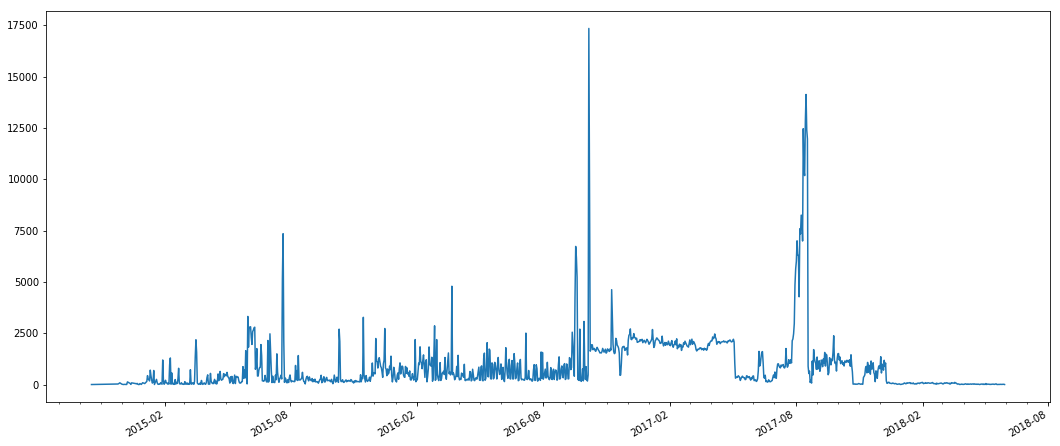

In [9]:
 #plotting goodies
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax=df.publish_date.value_counts().sort_index().plot(figsize=(18,8),legend=False)

# format the ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

In [10]:
#df_charlotte=df[(df.publish_date>dt.datetime(2017,8,11,0,0,0)) & (df.publish_date<dt.datetime(2017,8,13,0,0,0)) & (df.account_category=='RightTroll')]

### Interactive Plots

In [15]:
#interactive plot
p = figure(plot_width=850, plot_height=450, x_axis_type='datetime')
p.title.text = 'Tweeting activity according to Right and Left category'

categories=df.account_category.unique()

for color, category in enumerate(categories):
    df_plot = pd.DataFrame(df[df.account_category==category].publish_date.value_counts().sort_index())
    source = ColumnDataSource(data=df_plot)
    p.line(x='index', y='publish_date', source=source,\
            line_width=2, alpha=0.8, legend=category, color=Category10[3][color])


df_plot=pd.DataFrame(df.publish_date.value_counts().sort_index())   
source = ColumnDataSource(data=df_plot)
p.line(x='index', y='publish_date', line_width=2, alpha=0.3, legend='All', color=Category10[3][-1], source=source)


p.legend.location = 'top_left'
p.legend.click_policy='hide'

hover_tool=tools.HoverTool(
    tooltips=[
        ('Date', '@index{%F}'),
        ('Number of tweets','@publish_date')],

    formatters={
        'index' : 'datetime', # use 'datetime' formatter for 'date' field
        'publish_date' : 'printf',   },   # use 'printf' formatter for 'adj close' field

    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline'
)

p.tools.append(hover_tool)

output_notebook()#\interactive_legend.html\)# title=\interactive_legend.py example\)\n

Loading BokehJS ...

Pour desactiver uenc ourbe cliquer sur la légende. Pour desactiver le curseur (qui affiche les données), cliquer, à droite, sur l'icone |=|

Vous pouvez aussi zoomer.

In [21]:
show(p)

# Word analysis:

In [22]:
from sklearn.feature_extraction import DictVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')   

[nltk_data] Downloading package stopwords to /Users/Jean-
[nltk_data]     BaptistePROST/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### In Class version

In [43]:
def cleaning_content(df,dataset,  right=True, left=True):
    df_tmp=df[df.language=='English'].drop(columns={'harvested_date', 'language'})
    df_tmp=df.loc[:,['publish_date','content', 'account_category']]

    #category
    if not left:
        df_tmp=df_tmp[(df_tmp.account_category=='RightTroll')]
    elif not right:
        df_tmp=df_tmp[(df_tmp.account_category=='LeftTroll')]
    else:        
        df_tmp=df_tmp[(df_tmp.account_category=='RightTroll') | (df_tmp.account_category=='LeftTroll')  ]

    #date 
    df_tmp['publish_date']=df_tmp.publish_date.apply(lambda x: get_date(x))
    df_tmp=df_tmp[df_tmp.publish_date > dt.datetime(2014,10,1,0,0,0)].drop(columns='publish_date') #selecting after Oct 2014

    df_tmp['dataset']=dataset #from which datasetit comes

    return df_tmp

#def wm2df(wm, feat_names):

    # create an index for each row
#    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
#    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
#                     columns=feat_names)
#    return(df)    

class TweetWords(object):

    # tokenize the document
    def __init__(self,df):
        #for tokenizing
        self.link_numbers=('http', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
        self.stemmer = PorterStemmer()
        self.stop_w=stopwords.words('english')

        self.voc=pd.DataFrame()
        self.text=' '.join([ch for ch in df.content])

    def tokenize(self): #__call__
        text_raw = ''.join([ch for ch in self.text if ch not in string.punctuation])
        tokens = nltk.word_tokenize(text_raw)
        return [self.stemmer.stem(word.lower()).encode('ascii',errors='ignore').decode()\
                         for word in tokens if (not word.startswith(self.link_numbers))]

    def top_vocabulary(self, top=10):
        words = [word for word in self.tokenize() if word not in self.stop_w] 
        self.voc=self.voc.from_dict(Counter(words), orient='index')\
                .rename(columns={0:'Count'})\
                .sort_values(by='Count', ascending=False)[:top]
        return self.voc

data='data/russian-troll-tweets/IRAhandle_tweets_'

left=False
df=pd.DataFrame()
for dataset in range(1,9):
    df_tmp=cleaning_content(pd.read_csv(data+str(dataset)+'.csv'), dataset, left=left)
    df=df.append(df_tmp)

#### In *main* version

In [202]:
link_numbers=('http', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
stemmer = PorterStemmer()
stop_w=stopwords.words('english') + ['', '&amp', 'amp','rt']

def tokenize(text): #__call__
    text_raw = ''.join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text_raw)
    return [word.lower().encode('ascii',errors='ignore').decode()\
                     for word in tokens if (not word.startswith(link_numbers))]

def top_vocabulary(text, top=10):
    words = [stemmer.stem(word) for word in tokenize(text) if word not in stop_w] 
    voc=pd.DataFrame.from_dict(Counter(words), orient='index')\
            .rename(columns={0:'Count'})\
            .sort_values(by='Count', ascending=False)[:top]
    return voc


In [220]:
data='Data/russian-troll-tweets/IRAhandle_tweets_'

left=False
df_right=pd.DataFrame()

for dataset in range(1,9):
    df_tmp=cleaning_content(pd.read_csv(data+str(dataset)+'.csv'), dataset, left=left)
    df_right=df_right.append(df_tmp)

text_r=' '.join([ch for ch in df_right.content])

In [215]:
top_right=top_vocabulary(text_r,20)

In [216]:
right=False
df_left=pd.DataFrame()

for dataset in range(1,9):
    df_tmp=cleaning_content(pd.read_csv(data+str(dataset)+'.csv'), dataset, right=right)
    df_left=df_left.append(df_tmp)

text_l=' '.join([ch for ch in df_left.content])

In [217]:
top_left=top_vocabulary(text_l,20)

In [218]:
top_right

,Count
trump,102772
obama,35621
break,31504
hillari,29064
us,28245
video,22757
peopl,21689
new,21638
news,21245
presid,20858


In [219]:
top_left

,Count
black,27330
trump,23880
get,19537
peopl,19106
like,16507
new,14260
us,13595
white,13523
blacklivesmatt,12975
dont,12763
